In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 8.6MB/s 


In [0]:
!cp /content/drive/'My Drive'/test_task/bert.py .
!cp /content/drive/'My Drive'/test_task/utils.py .

In [0]:
from bert import *
from utils import *

100%|██████████| 231508/231508 [00:00<00:00, 899889.47B/s]


In [0]:
from pytorch_pretrained_bert import BertConfig
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import pickle
import torch.optim as optim

Let's define the configuration of our model

In [0]:
config = BertConfig(vocab_size_or_config_json_file=32000, 
                    hidden_size=768,
                    num_hidden_layers=12,
                    num_attention_heads=12,
                    intermediate_size=3072)

num_labels = 5

In [0]:
model = BertForSequenceClassification(config, num_labels)

100%|██████████| 407873900/407873900 [00:15<00:00, 26522987.62B/s]


First of all, let's have a look at the target distribution.

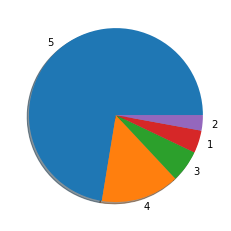

In [0]:
import pandas as pd
df = pd.read_json("/content/drive/My Drive/test_task/reviews.json", lines=True)
x = df['overall'].value_counts()
plt.pie(x, labels = x.index, shadow=True)
plt.show()

As we can see, there are much more good marks, so we deal with the unbalanced dataset. Let's still just text fields and target and transform target to valid format for our model, as it has to looks like [0, 1, 2, 3, 4]

In [0]:
df = df[['reviewText', 'summary', 'overall']]
df.loc[:, 'overall'] = df.overall.apply(lambda target: target -1)

X = df.drop(columns=['overall'])
y = df['overall']

Also, we will need to know lengths of tests, so let's visualize it:

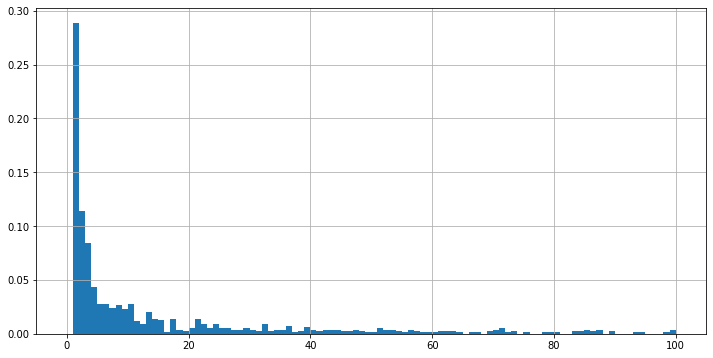

In [0]:
df['reviewText'].astype(str).str.split().apply(len).value_counts().sort_index().hist(bins = 100, range = (0, 100), density = True, figsize = (12, 6));

There are reviews even longer than 100 tokens, but most pars of them are shorter and I decided to consider that part. I would like to choose the length of 60 (shorter will be padded, which longer will be truncated) to save time on training. It possible to put longer sequences into the transformer, but we will not use this benefit now.

In [0]:
max_seq_length = 60

As we have really huge dataset, training on whole data will take probably several days, so I would like to use a subsample from the dataset.

As data is unbalanced, we need to do a representative subsample. To do this, we will use StratifiedShuffleSplit.

In [0]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
_, sample_index = next(sss.split(X, y))

sub_sample = df.iloc[sample_index]

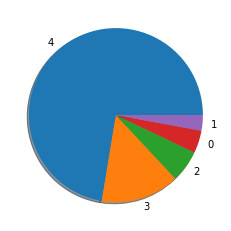

In [0]:
x = sub_sample['overall'].value_counts()
plt.pie(x, labels = x.index, shadow=True)
plt.show()

Looks like that we needed.

Getting the feature column and target:

In [0]:
X = sub_sample['reviewText'].astype(str)
y = sub_sample['overall']

At this step, we will split our data to train and validation dataset (60% for training and another for validation) 

In [0]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=0)
train_idxs, validation_idxs = next(sss.split(X, y))

X_train = X.iloc[train_idxs].to_list()
y_train = y.iloc[train_idxs].to_list()

X_val = X.iloc[validation_idxs].to_list()
y_val = y.iloc[validation_idxs].to_list()

As I plan to use several models, I found useful to save indexes of train and val. data to use them in the future:

In [0]:
indexes = (train_idxs, validation_idxs)
with open('/content/drive/My Drive/test_task/indexes.pickle', 'wb') as f:
    pickle.dump(indexes, f)

Let's put our data to dataloader using our class 'text_dataset'

In [0]:
batch_size = 128

train_lists = [X_train, y_train]
val_lists = [X_val, y_val]

training_dataset = text_dataset(x_y_list = train_lists, max_seq_length = max_seq_length)
test_dataset = text_dataset(x_y_list = val_lists, max_seq_length = max_seq_length)

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, 
                                                         batch_size=batch_size, 
                                                         shuffle=True, 
                                                         num_workers=0),
                    'val':torch.utils.data.DataLoader(test_dataset, 
                                                      batch_size=batch_size, 
                                                      shuffle=False, 
                                                      num_workers=0)}

dataset_sizes = {'train':len(train_lists[0]),
                 'val':len(val_lists[0])}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

This is an important step where we will define two learning rates: the first one for the last layer and the second one for pre-trained Bert. As we don't want to change weights in a pre-trained part the second lr will be much lower than first.

Also, we will use a step scheduler to decrease lr at every 4 steps (but probably, we will even do these steps as it takes much time.

In [0]:
lrlast = .001
lrmain = .00001
optimizer = optim.Adam([
                        {"params":model.bert.parameters(),"lr": lrmain},
                        {"params":model.classifier.parameters(), "lr": lrlast},
                      ])

criterion = nn.CrossEntropyLoss()

# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_name = 'review_preds'

Let's train it!

(By unknown reason using scheduler before optimizer.steps() usually gives better performance even if I would use smaller learning rate on the very beginning, so let's ignore this warning ; )

In [0]:
model, review_preds = train_model(model, model_name, criterion, optimizer, exp_lr_scheduler, dataloaders_dict, dataset_sizes, device, num_epochs=3)

starting
Epoch 1/3
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train total loss: 0.7513 
train F-1 score : 0.7391 
val total loss: 0.6631 
val F-1 score : 0.7609 
saving with loss of 0.6630992859840393 improved over previous 100

Epoch 2/3
----------
train total loss: 0.6303 
train F-1 score : 0.7687 
val total loss: 0.6313 
val F-1 score : 0.7694 
saving with loss of 0.6312508131980896 improved over previous 0.6630992859840393

Epoch 3/3
----------
train total loss: 0.5861 
train F-1 score : 0.7818 
val total loss: 0.6277 
val F-1 score : 0.7728 
saving with loss of 0.6277210783958435 improved over previous 0.6312508131980896

Training complete in 24m 12s
Best val loss: 0.627721


Looks not bad, so let's save predictions on validation part, as I plan to da Blend then

In [0]:
with open('/content/drive/My Drive/test_task/review_preds.pickle', 'wb') as f:
    pickle.dump(review_preds, f)

Summary column's texts look pretty same to reviews, so I will take the same length

In [0]:
max_seq_length = 60

The same steps for next column

In [0]:
X = sub_sample['summary'].astype(str)

In [0]:
X_train = X.iloc[train_idxs].to_list()
X_val = X.iloc[validation_idxs].to_list()

In [0]:
batch_size = 128

train_lists = [X_train, y_train]
val_lists = [X_val, y_val]

training_dataset = text_dataset(x_y_list = train_lists, max_seq_length = max_seq_length)
test_dataset = text_dataset(x_y_list = val_lists, max_seq_length = max_seq_length)

dataloaders_dict = {'train': torch.utils.data.DataLoader(training_dataset, 
                                                         batch_size=batch_size, 
                                                         shuffle=True, 
                                                         num_workers=0),
                    'val':torch.utils.data.DataLoader(test_dataset, 
                                                      batch_size=batch_size, 
                                                      shuffle=False, 
                                                      num_workers=0)}

dataset_sizes = {'train':len(train_lists[0]),
                 'val':len(val_lists[0])}

In [0]:
model = BertForSequenceClassification(config, num_labels)
model_name = 'summury_preds'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

In [0]:
model, summury_preds = train_model(model, model_name, criterion, optimizer, exp_lr_scheduler, dataloaders_dict, dataset_sizes, device, num_epochs=5)

starting
Epoch 1/5
----------
train total loss: 1.0865 
train F-1 score : 0.6418 
val total loss: 1.0565 
val F-1 score : 0.7041 
saving with loss of 1.0564682235717773 improved over previous 100

Epoch 2/5
----------
train total loss: 1.0850 
train F-1 score : 0.6445 
val total loss: 1.0565 
val F-1 score : 0.7041 

Epoch 3/5
----------
train total loss: 1.0844 
train F-1 score : 0.6425 
val total loss: 1.0565 
val F-1 score : 0.7041 

Epoch 4/5
----------
train total loss: 1.0868 
train F-1 score : 0.6422 
val total loss: 1.0565 
val F-1 score : 0.7041 

Epoch 5/5
----------
train total loss: 1.0855 
train F-1 score : 0.6412 
val total loss: 1.0565 
val F-1 score : 0.7041 

Training complete in 36m 42s
Best val loss: 1.056468


I thought that this column will be easier for Bert than previous, anyway let's save predictions and target (it will be useful too)

In [0]:
with open('/content/drive/My Drive/test_task/summury_preds.pickle', 'wb') as f:
    pickle.dump(summury_preds, f)

In [0]:
with open('/content/drive/My Drive/test_task/target.pickle', 'wb') as f:
    pickle.dump(y_val, f)